# Detecting Emotions in Headlines

### Part II: Models

Kelly Epley

![media](images/image-3895819_1920.jpg)

This notebook documents techiniques used to identify the emotions present in news headlines.

The dataset contains 1,250 headlines from a variety of news sources. Each is rated for six emotion categories: anger, disgust, fear, joy, sadness, and suprise. 

I used multilabel classification techniques from skmultilearn and keras to generate a prediction model that can detect the presence of each of the six emotion labels.

### Collecting Packages

In [2]:
# basic packages
import pandas as pd
import numpy as np
import itertools
import random

# vectorizer, classifiers, and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, jaccard_score, hamming_loss, log_loss
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance 
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split

# rnn
from gensim.models import KeyedVectors
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import rmsprop
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

# custom functions, class to import and process data
from get_labeled_dfs import *
from process_text import *

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Preprocessing Data and Labels

##### The corpus dataframe

I used a custom preprocessing class to prepare my text data, which:
* converts all text to lower case
* removes punctuation (except for exclamation points and question marks) 
* removes numeric characters
* removes stopwords
* lemmatizes words (converts words to their roots)

I opted to leave exclamation points and question marks in the data because they are relevant in determining the attitude conveyed in a sentence. I split them apart from the words they follow so that they'll be counted separately (e.g. 'hooray!' becomes 'hooray', '!'). 

The stopwords list is a modified version of [Princeton's]('https://algs4.cs.princeton.edu/35applications/stopwords.txt'). Standard stopwords lists such as this generally require culling for emotion identification tasks because they include words that are relevant to emotion-identification. I removed words such as "appreciate" and "against" from the list because they express positive or negative attitudes and words such as "very" because they matter in determining the intensity of an emotion.  

##### The emotion label dataframe

The emotion label dataframe contains ratings for each emotion. I added a max rating column during data exploration. I also added label columns, which are populated with ones and zeros. A one indicates that the emotion is present (it has a non-zero rating), A zero indicates that it is not.  

In [3]:
# use custom function to get the corpus df and emotion labels 
corpus_df, emotion_df, _ = get_labeled_dfs()

# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [4]:
# inspect corpus
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,hussein ally hang iraqi official
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [5]:
# inspect labels
emotion_df.head()


,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


### Multilabel Classification Evaluation Metrics

I've compiled evaluation metrics in two functions. One is for evaluating how a model performs with respect to each individual emotion label. The other is a set of summary scores useful for comparing a model's overall performace with other models.

##### Individual emotion labels

I used confusion matrices to inspect predicted labels vs. actual labels.

To compare performace on individual labels, I used accuracy, precision, recall, and f1 scores.

* Accuracy score tells us the ratio of correct predictions to total predictions 

* Precision score tells us the ratio of correct predictions to total predictions of the target class 

* Recall score tells us the ratio of correct predictions to the total true cases of the taget class

* F1 is a weighted average of precision and recall

I include all four of these metrics because the emotion labels are, to varying degress, imbalanced. (There are unequal ratios of headlines with the emotion present and headlines with the emotion absent.) Because the labels are imbalanced, accuracy is not always diagnosticn. When a label is imbalanced, it's necessary to look at F1 and its components, precision and recall, to see whether the model can identify both presence and absence of the emotion correctly.


In [136]:
def label_scores(lst, df, figtitle, RNN=False):
    
    '''A function that creates confusion matrices and calculates accuracy, precision, 
    recall, and f1 for each individual label'''
    
    plt.figure(figsize=(15,10))
    subplot_num = 1
    
    # calculate true positives, false positives, false negatives, and true negatives
    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        # plot confusion matrix
        plt.subplot(2,3,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        # calculate and print accuracy, precision, recall, and f1
        accuracy = tp/(fp + tn + tp + fn)
        precision = tp/(fp + tp)
        recall = tp/(tp + fn)
        f1 = 2 * ((precision * recall) / (precision + recall))
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", f1)
        print('\n')
        
    # save confusion matrix
    plt.savefig(figtitle)

        

##### Overall Performance

To evaluate a model's performance on the whole set of possible labels, I compare jaccard similarity, hamming loss, and f1 macro scores.

* Jaccard similarity is the ratio of correct labels to total predictions.
* Hamming loss is the ratio of incorrect labels to total predictions.
* F1 macro is F1 for the whole set of labels.

Note that Jaccard Similarity and Hamming loss both count the correct or incorrect labels for each individual label and add them together. I use these metrics rather than ones requiring a perfect match across all labels because it's useful to know whether a model can predict subsets of the correct labels at a higher rate than others. This requires metrics that do not treat a prediction that gets five out of six labels correct the same as one that gets zero out of six correct.

In [137]:
def overall_scores(y_true, y_pred):
    
    '''A function that calculates jaccard similarity, hamming loss, f1 macro, 
    and log loss to assess the model's overall performance'''
    
    jaccard_score_micro = jaccard_score(y_true, y_pred, average='micro')
    hamming_loss_score = hamming_loss(y_true, y_pred)
    f1_micro_score = f1_score(y_true, y_pred, average='micro')
    
    print('jaccard score micro:', round(jaccard_score_micro, 3))
    print('hamming loss:', round(hamming_loss_score, 3))
    print('f1 micro:', round(f1_micro_score, 3))
    

### Train-Test Split

I split the data into training and testing sets using skmultilearn's iterative_train_test_split. This ensures that labels are distributed as evenly as possibile.

In [138]:
# Split the data into separate training and testing sets 
random.seed(22)
X_train, y_train, X_test, y_test = iterative_train_test_split(corpus_df.values, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']].values, test_size=.25)

# Check to see that the labels are evenly divided
print('Percent of each label appreaing in the test set:')
print("   Anger:", y_test[:,0].sum()/(y_test[:,0].sum()+y_train[:,0].sum()))
print("   Disgust:", y_test[:,1].sum()/(y_test[:,1].sum()+y_train[:,1].sum()))
print("   Fear:", y_test[:,2].sum()/(y_test[:,2].sum()+y_train[:,2].sum()))
print("   Joy:", y_test[:,3].sum()/(y_test[:,3].sum()+y_train[:,3].sum()))
print("   Sadness", y_test[:,4].sum()/(y_test[:,4].sum()+y_train[:,4].sum()))
print("   Surprise:", y_test[:,5].sum()/(y_test[:,5].sum()+y_train[:,5].sum()))


Percent of each label appreaing in the test set:
   Anger: 0.24846625766871167
   Disgust: 0.24571428571428572
   Fear: 0.24634146341463414
   Joy: 0.2506361323155216
   Sadness 0.2410196987253766
   Surprise: 0.24954627949183303


### TF-IDF Vectorization

The data needs to be transformed into a numeric format before it can be used to train a model. 

One option is to use a "Bag of Words" representation of the text. By [this](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) method, each document is represented by a count for each word that is present. 

As an example, I'll use the opening lines of Dickens's *Tale of Two Cities*: "It was the best of times, it was the worst of times" and "It was the age of wisdom, it was the age of foolishness."

Each row is a document and each column is a word in the corpus.

| it | was | the | best | of | times | worst | age | wisdom | foolishness |  
|----|-----|-----|------|----|-------|-------|-----|--------|-------------|
|2   |2    |2    |1     |2   |2      |1      |0    |0       |0            |
|2   |2    |2    |0     |2   |0      |0      |2    |1       |1            |

Another option is to use term frequency-inverse document frequency ([TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)). TF-IDF is a representation of how import a word is in distinguishing a document from other documents in the corpus. The higher the score, the more important the word.

It's calculated by multiplying term frequency by inverse document frequency (with a constant added to avoid any divisions by zero when the vectorizer is applied to new data).

* Term Frequency: times the word appears in the document/number of words in the document

* Inverse Document Frequency: log(number of documents in the corpus/number documents in the corpus in which the word appears)

See the DataFrame in the cell below to see how it looks on the same example.

Using TF-IDF keeps models from treating words that aren't distinguishing to a document as significant in determining whether other documents should have the same label.

In [139]:
df = pd.DataFrame({'text':['it was the best of times it was the worst of times','it was the age of wisdom it was the age of foolishness']})

vectorizer = TfidfVectorizer(smooth_idf=False)
test = vectorizer.fit_transform(df['text'])
pd.DataFrame(test.toarray(), columns=['age', 'best', 'foolishness', 'it', 'of', 'the', 'times', 'was', 'wisdom', 'worst'])

# use vectorizer.vocabulary_ to get a dictionary of the column numbers

,age,best,foolishness,it,of,the,times,was,wisdom,worst
0,0.000000,0.293848,0.000000,0.347103,0.347103,0.347103,0.587696,0.347103,0.000000,0.293848
1,0.587696,0.000000,0.293848,0.347103,0.347103,0.347103,0.000000,0.347103,0.293848,0.000000


In [140]:
# flatten X_train and X_test
X_train_flat = []
for i in X_train:
    for j in i:
        X_train_flat.append(j)

X_test_flat = []
for i in X_test:
    for j in i:
        X_test_flat.append(j)

# Use TfidVectorizer to get a sparse matrix of TF-IDF scores for each word in the corpus.
# Fit to training data and then use it to transform the test data.
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(pd.DataFrame({'text':X_train[:,0]})['text'])
X_test = vectorizer.transform(pd.DataFrame({'text': X_test[:,0]})['text'])


### Binary Relevance Classification Model

An important consideration in choosing a multilabel prediction model is whether the labels are independent or correlated. There is strong correlation between the anger and disgust labels in my dataset and moderate correlation between several other labels.

![correlations](images/emotion_correlations.png)

My simplest model assumes that they are independent. I used a Binary Relevance Classification model with a Logistic Regression estimator. 

Binary Relevance trains a separate model for each label in the dataset. Each model's predictions are independent of all the others.


In [141]:
# Fit data to a Binary Relevance classifier with a Logisitic Regression estimator
LR = LogisticRegression()
BR = BinaryRelevance(LR)
BR.fit(X_train, y_train)

BinaryRelevance(classifier=LogisticRegression(C=1.0, class_weight=None,
                                              dual=False, fit_intercept=True,
                                              intercept_scaling=1,
                                              l1_ratio=None, max_iter=100,
                                              multi_class='warn', n_jobs=None,
                                              penalty='l2', random_state=None,
                                              solver='warn', tol=0.0001,
                                              verbose=0, warm_start=False),
                require_dense=[True, True])

In [142]:
# Predict on the training and test sets
BR_train_preds = BR.predict(X_train).toarray()
BR_test_preds = BR.predict(X_test).toarray()

emotion_pred_labels = ['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label']
emotion_labels = ['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']

# Create a prediction df
BR_preds_df = pd.DataFrame(BR_test_preds, columns=emotion_pred_labels)
y_test_df = pd.DataFrame(y_test, columns=emotion_labels)
BR_preds_df = pd.concat([BR_preds_df, y_test_df], axis=1)

In [143]:
# Get BR Train Scores
overall_scores(y_train, BR_train_preds)

jaccard score micro: 0.825
hamming loss: 0.132
f1 micro: 0.904


In [144]:
# get BR Overall Test Scores
overall_scores(y_test, BR_test_preds)

jaccard score micro: 0.689
hamming loss: 0.256
f1 micro: 0.816


anger_label accuracy: 0.42443729903536975
anger_label precision: 0.7542857142857143
anger_label recall 0.8148148148148148
anger_label f1 0.7833827893175074


disgust_label accuracy: 0.19292604501607716
disgust_label precision: 0.8
disgust_label recall 0.46511627906976744
disgust_label f1 0.5882352941176471


fear_label accuracy: 0.6366559485530546
fear_label precision: 0.6875
fear_label recall 0.9801980198019802
fear_label f1 0.8081632653061225


joy_label accuracy: 0.6045016077170418
joy_label precision: 0.6836363636363636
joy_label recall 0.9543147208121827
joy_label f1 0.7966101694915253


sadness_label accuracy: 0.662379421221865
sadness_label precision: 0.6889632107023411
sadness_label recall 0.9903846153846154
sadness_label f1 0.8126232741617356


surprise_label accuracy: 0.8842443729903537
surprise_label precision: 0.8842443729903537
surprise_label recall 1.0
surprise_label f1 0.9385665529010239




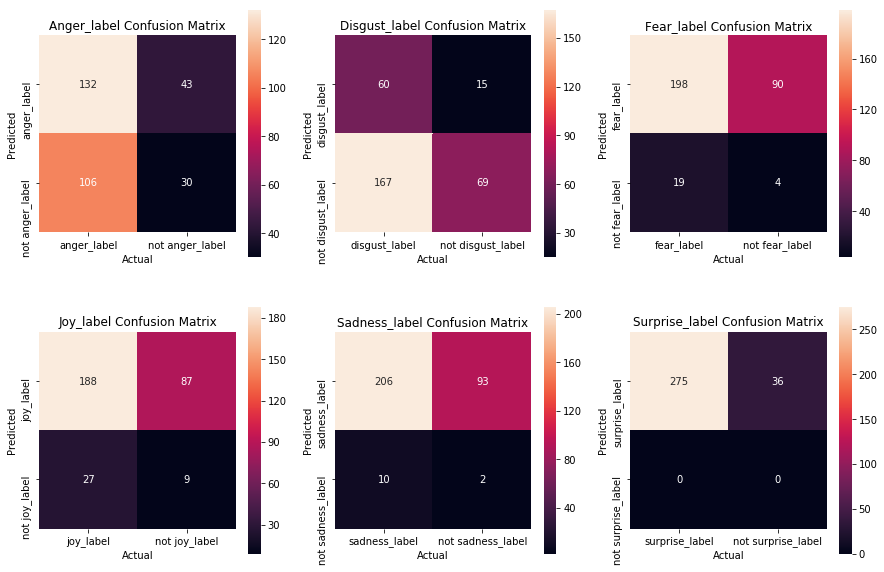

In [145]:
# Get BR Label Test Scores 
label_scores(emotion_labels, BR_preds_df, 'BR_LR_CM')

### Compare: Classifier Chain

Since there is some correlation among the emotion labels, I compared my Binary Relevance Classifier to a Classifier Chain. A Classifier Chain sequentially trains a model for each label in the dataset, and each model's predictions are transferred to the next model. This allows probabistic relationships between labels to have an impact on the model's predictions.

Classifiers Chains are sensitive to label order, so I tested all 750 possible label orders to find the best one. If my dataset were significantly larger or if I had significantly more label combinations to test, this would have been too computationally expensive, and it would have been more practical to do a random selection of label orders to test. 

The Classifier Chain and the Binary Relevance model perform roughly the same in terms of their overall scores, but note that the classifier chain does better with respect to disgust, which is the least common label and hence the most difficult to get models to detect. Presumably, the model detects the correlation between anger and disgust and predicts accordingly.

Also note that neither model predicts that any headline does not contain suprise. This can happen with labels that are overrepresented in a dataset because the prior probability of something's having that label is so high that the model always predicts it regardless of the evidence. I will address this problem using class weights in the final model.


In [146]:
perms = list(itertools.permutations([0,1,2,3,4,5]))

chains = [ClassifierChain(LR, order=perms[i]) for i in range(720)]

results_jaccard = []
preds = []
for chain in chains:
    chain.fit(X_train, y_train)
    test_preds = chain.predict(X_test)
    preds.append(test_preds)
    results_jaccard.append(jaccard_score(y_test, test_preds, average='micro'))

In [147]:
# Fit the training data on the Chain Classifier with the best label order
CC_best_order = chains[results_jaccard.index(max(results_jaccard))].fit(X_train, y_train)

# Predict on the training and test sets
CC_train_preds = CC_best_order.predict(X_train).toarray()
CC_test_preds = CC_best_order.predict(X_test).toarray()

# Create a test prediction df
CC_preds_df = pd.DataFrame(CC_test_preds, columns=emotion_pred_labels)
CC_preds_df = pd.concat([CC_preds_df, y_test_df], axis=1)

In [148]:
# Get CC Train Scores
overall_scores(y_train, CC_train_preds)

jaccard score micro: 0.816
hamming loss: 0.131
f1 micro: 0.899


In [149]:
# Get CC Test Scores
overall_scores(y_test, CC_test_preds)

jaccard score micro: 0.678
hamming loss: 0.246
f1 micro: 0.808


anger_label accuracy: 0.42443729903536975
anger_label precision: 0.7542857142857143
anger_label recall 0.8148148148148148
anger_label f1 0.7833827893175074


disgust_label accuracy: 0.3311897106109325
disgust_label precision: 0.5885714285714285
disgust_label recall 0.7984496124031008
disgust_label f1 0.6776315789473683


fear_label accuracy: 0.5401929260450161
fear_label precision: 0.8155339805825242
fear_label recall 0.8316831683168316
fear_label f1 0.8235294117647058


joy_label accuracy: 0.3762057877813505
joy_label precision: 0.8013698630136986
joy_label recall 0.5939086294416244
joy_label f1 0.6822157434402333


sadness_label accuracy: 0.5498392282958199
sadness_label precision: 0.8341463414634146
sadness_label recall 0.8221153846153846
sadness_label f1 0.828087167070218


surprise_label accuracy: 0.8842443729903537
surprise_label precision: 0.8842443729903537
surprise_label recall 1.0
surprise_label f1 0.9385665529010239




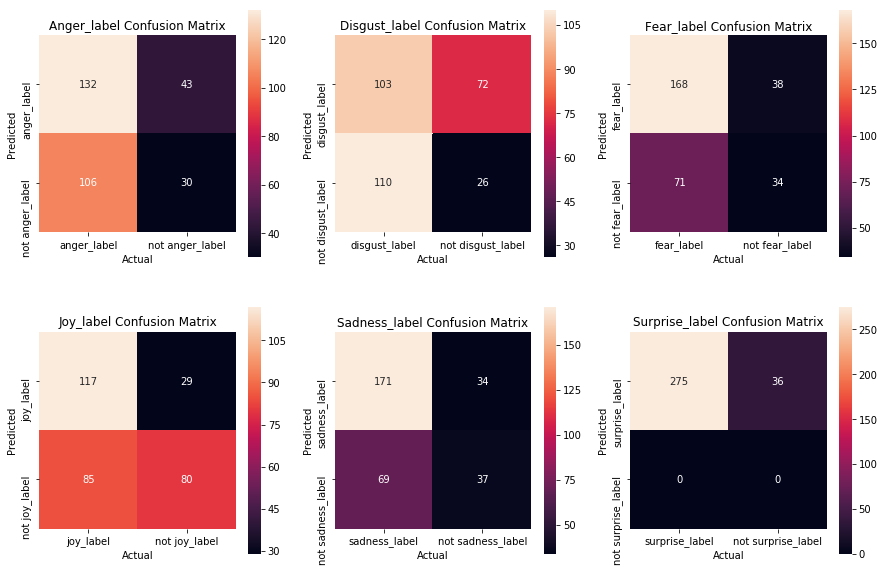

In [150]:
label_scores(emotion_labels, CC_preds_df, 'CC_LR_CM')

# Recurrent Neural Network

I get a slight but consistent improvement in the model using a Recurrent Neural Network (RNN).

RNN is designed to handle data that is is sequential. When it comes to natural language processing, this is a big advantage over "Bag of Words" and TF-IDF techniques, which can account for the presence of words in a document, but not their order. 

For RNN, I use vector representations of the words in the documents. These vectors represent the euclidain distance between words, determined by a word-to-vector model. A well constructed word-to-vector model can capture relationships between concepts so that, for example, you can subtract the vector representing "France" from "Paris" and then add "Italy" to get the vector for "Rome", or something very close ([source]('https://code.google.com/archive/p/word2vec/')). 

Instead of training my own word-to-vector model on the limited dataset I'm predicting, I made use of vectors that [Google]('https://code.google.com/archive/p/word2vec/') trained using enormous datasets.

For RNN, I pared back my text preprocessing. I converted words to lower case and remove dpunctuation (except for exclamation points and question marks), but I did not remove stopwords or lemmatize. 

The model is deployed is the front_page() class. See the notebook titled "Front_Page" for a demo.


In [122]:
# use custom function to get the corpus df and labels 
corpus_df_RNN, _, _ = get_labeled_dfs()

# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df_RNN, RNN=True)


In [123]:
# Create vectors
w2v = KeyedVectors.load_word2vec_format('/Users/flatironschool/Desktop/Detecting_Emotions/data/GoogleNews-vectors-negative300.bin',
        binary=True)

# Assign a unique number to each word in the corpus and represents texts via these numbers
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(corpus_df_RNN['text']))
sequences = tokenizer.texts_to_sequences(corpus_df_RNN['text'])

# Add zeros to the end of each sequence as necessary to make them all the same length
padded_data = sequence.pad_sequences(sequences, maxlen=15, padding='post')
       

In [124]:
# Create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# Fill the array with word vectors corresponding to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in w2v.vocab.keys():
        embedding_matrix[ind + 1, :] = w2v[word]
        

In [125]:
# Divide data into training and test sets
random.seed(99)
X_train, y_train, X_test, y_test = iterative_train_test_split(padded_data, emotion_df[emotion_labels].values, test_size=.25)

# Check to see that the labels are evenly divided
print('Percent of each label appreaing in the test set')
print("   Anger:", y_test[:,0].sum()/(y_test[:,0].sum()+y_train[:,0].sum()))
print("   Disgust:", y_test[:,1].sum()/(y_test[:,1].sum()+y_train[:,1].sum()))
print("   Fear:", y_test[:,2].sum()/(y_test[:,2].sum()+y_train[:,2].sum()))
print("   Joy:", y_test[:,3].sum()/(y_test[:,3].sum()+y_train[:,3].sum()))
print("   Sadness", y_test[:,4].sum()/(y_test[:,4].sum()+y_train[:,4].sum()))
print("   Surprise:", y_test[:,5].sum()/(y_test[:,5].sum()+y_train[:,5].sum()))

Percent of each label appreaing in the test set
   Anger: 0.25306748466257667
   Disgust: 0.24
   Fear: 0.24634146341463414
   Joy: 0.24936386768447838
   Sadness 0.23870220162224798
   Surprise: 0.25045372050816694


In [126]:
# Build neural network
model = Sequential()

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=15, trainable=False))

model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.0025, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train,
                    epochs=50,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0: 200, 1: 1}, {0: 250, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 150}],
                    validation_data=(X_test, y_test))

Train on 942 samples, validate on 308 samples
Epoch 1/50
942/942 [==============================] - 4s 4ms/step - loss: 0.7780 - acc: 0.5778 - val_loss: 0.6650 - val_acc: 0.6867
Epoch 2/50
942/942 [==============================] - 1s 533us/step - loss: 0.6443 - acc: 0.6610 - val_loss: 0.6704 - val_acc: 0.6878
Epoch 3/50
942/942 [==============================] - 1s 544us/step - loss: 0.5734 - acc: 0.7044 - val_loss: 0.5912 - val_acc: 0.7311
Epoch 4/50
942/942 [==============================] - 1s 594us/step - loss: 0.5404 - acc: 0.7376 - val_loss: 0.6210 - val_acc: 0.7581
Epoch 5/50
942/942 [==============================] - 1s 796us/step - loss: 0.4867 - acc: 0.7689 - val_loss: 0.5896 - val_acc: 0.7738
Epoch 6/50
942/942 [==============================] - 1s 629us/step - loss: 0.4577 - acc: 0.7895 - val_loss: 0.5476 - val_acc: 0.7624
Epoch 7/50
942/942 [==============================] - 1s 1ms/step - loss: 0.4401 - acc: 0.8018 - val_loss: 0.5761 - val_acc: 0.7857
Epoch 8/50
942/942 [

308/308 [==============================] - 0s 518us/step


[0.5312182717509084, 0.7840908990277873]

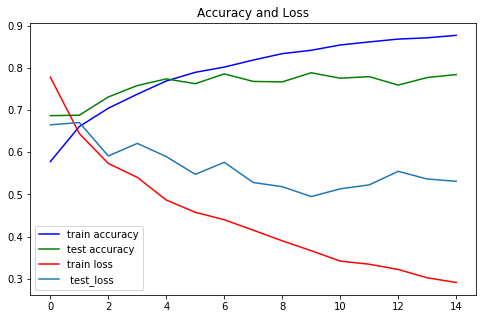

In [127]:
# Plot accuracy and loss for training and test sets
plt.figure(figsize=(8,5))

plt.plot(model.history.history['acc'], color='blue', label='train accuracy')
plt.plot(model.history.history['val_acc'], color='green', label='test accuracy')

plt.plot(model.history.history['loss'], color='red', label='train loss')
plt.plot(model.history.history['val_loss'], label=' test_loss')

plt.title("Accuracy and Loss")
plt.legend()

model.evaluate(X_test, y_test)

In [128]:
# save model 
model.save('RNN_multiclass_emotion.h5')

# make train predictions
RNN_train_preds = model.predict_on_batch(X_train)

# make test predictions
RNN_test_preds = model.predict_on_batch(X_test)

# make prediction databases
RNN_train_preds_df = pd.DataFrame({"pred_anger_label":RNN_train_preds[:,0], "pred_disgust_label":RNN_train_preds[:,1], "pred_fear_label":RNN_train_preds[:,2], "pred_joy_label":RNN_train_preds[:,3], "pred_sadness_label":RNN_train_preds[:,4], "pred_surprise_label":RNN_train_preds[:,5], "anger_label":y_train[:,0], "disgust_label":y_train[:,1], "fear_label": y_train[:,2], "joy_label": y_train[:,3], "sadness_label": y_train[:,4], "surprise_label": y_train[:,5]})
RNN_test_preds_df = pd.DataFrame({"pred_anger_label":RNN_test_preds[:,0], "pred_disgust_label":RNN_test_preds[:,1], "pred_fear_label":RNN_test_preds[:,2], "pred_joy_label":RNN_test_preds[:,3], "pred_sadness_label":RNN_test_preds[:,4], "pred_surprise_label":RNN_test_preds[:,5], "anger_label":y_test[:,0], "disgust_label":y_test[:,1], "fear_label": y_test[:,2], "joy_label": y_test[:,3], "sadness_label": y_test[:,4], "surprise_label": y_test[:,5]})


In [129]:
# Get RNN Train Scores
overall_scores(y_train, RNN_train_preds>.5)


jaccard score micro: 0.871
hamming loss: 0.088
f1 micro: 0.931


In [130]:
# Get RNN Test Scores
overall_scores(y_test, RNN_test_preds>.5)


jaccard score micro: 0.71
hamming loss: 0.216
f1 micro: 0.83


anger_label accuracy: 0.40584415584415584
anger_label precision: 0.8116883116883117
anger_label recall 0.7575757575757576
anger_label f1 0.7836990595611286


disgust_label accuracy: 0.2922077922077922
disgust_label precision: 0.6923076923076923
disgust_label recall 0.7142857142857143
disgust_label f1 0.7031250000000001


fear_label accuracy: 0.5227272727272727
fear_label precision: 0.8385416666666666
fear_label recall 0.7970297029702971
fear_label f1 0.817258883248731


joy_label accuracy: 0.5064935064935064
joy_label precision: 0.8
joy_label recall 0.7959183673469388
joy_label f1 0.7979539641943735


sadness_label accuracy: 0.564935064935065
sadness_label precision: 0.8446601941747572
sadness_label recall 0.8446601941747572
sadness_label f1 0.8446601941747571


surprise_label accuracy: 0.8733766233766234
surprise_label precision: 0.893687707641196
surprise_label recall 0.9746376811594203
surprise_label f1 0.9324090121317158




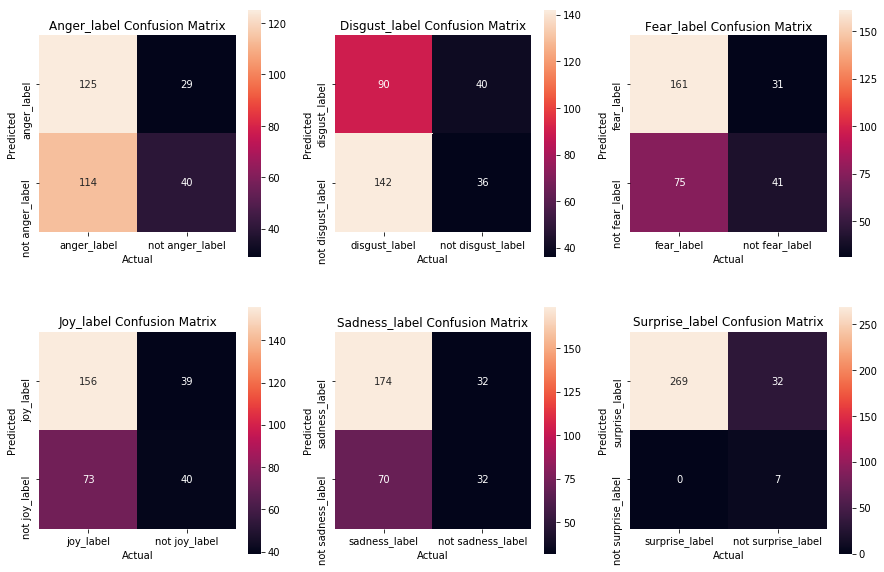

In [131]:
# Get RNN Label Scores 
label_scores(emotion_labels, RNN_test_preds_df, figtitle='RNN_CM', RNN=True)
